Sample based on event information from INGV catalog

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx

#select particular representative gauge
reg = 'CT'

if reg == 'SR':
    columnname = str(54)
elif reg == 'CT':
    columnname = str(41)


MLDir = '/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami' 

eve_info = pd.read_csv(f'{MLDir}/resources/processed/allinfo_eventsBS_PS53550.txt',sep=',')
offshore_info = pd.read_csv(f'{MLDir}/data/info/grid0_allpts87_alleve53550.offshore.txt',sep='\t')
onshore_info = pd.read_csv(f'{MLDir}/data/info/CDepth_{reg}_alleve53550.onshore.txt',sep='\t')

#add eve_id to offshore_info and onshore_info by splitting id at /

#mange id column
eve_info.rename(columns={'ID':'eve_id'}, inplace=True)
offshore_info['eve_id'] = offshore_info['id'].str.split('/').str[1]
onshore_info['eve_id'] = onshore_info['id'].str.split('/').str[1]

#keep only column gaugeno and eve_id
offshore_info = offshore_info[['eve_id',columnname]]
# onshore_info = onshore_info[['eve_id','max']]

#merge offshore and onshore
combined = pd.merge(offshore_info, onshore_info, on='eve_id', how='left')

#merge combined with eve_info
combined = pd.merge(combined, eve_info, on='eve_id', how='left')



Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ajzl4jiw because the default path (/home/naveen.raguramalinga/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/tmp/ipykernel_422919/1450540750.py:17: DtypeWarning: Columns (6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  eve_info = pd.read_csv(f'{MLDir}/resources/processed/allinfo_eventsBS_PS53550.txt',sep=',')


In [52]:
#get column names
# combined.columns.values.tolist()
# ['eve_id',
#  '41', #offshore gauge selected for sampling
#  'id',
#  'count',
#  'max',
#  'logsum',
#  'mean',
#  'sd',
#  'dzmin',
#  'dzmax',
#  'Source_Region',
#  'Type',
#  'Mag',
#  'lon',
#  'lat',
#  'SlipModel',
#  'Scaling',
#  'RuptureModel',
#  'Rigidity',
#  'Depth',
#  'Strike',
#  'Dip',
#  'Rake',
#  'Length',
#  'Area',
#  'Slip',
#  'Location',
#  'LocationCount',
#  'mean_prob']



In [2]:

#create a new dataframe with only the columns we need
combined = combined[['eve_id','id',columnname,'mean_prob','dzmax','dzmin','max','lon','lat','Location','LocationCount']]

#rename column gauge to max_off and change type to double
combined.rename(columns={columnname:'max_off'}, inplace=True)
combined['max_off'] = combined['max_off'].astype(np.double)

#get max abs deformation
combined['max_absdz'] = combined[['dzmax','dzmin']].abs().max(axis=1)

#if absolute value of dzmax or dzmin is less than 0.1, set event_type to 'near'(0) ie  else 'far'(1)
combined['event_type'] = combined['max_absdz'].apply(lambda x: 1 if abs(x)<0.1 else 0).astype(np.double)
# combined['event_type'] = combined['dzmax'].apply(lambda x: 1 if x<0.2 else 0).astype(np.double)

#importance variable
combined['importance'] = combined['mean_prob'] * combined['max_off'].astype(np.double)

# #count when importance is 0
# combined[combined['importance']==0]
# #set importance to 1e-10  if importance is 0
# combined['importance'] = combined['importance'].apply(lambda x: 1e-10 if x==0 else x)


#count number of events in each cluster of event_type
print(combined.groupby('event_type').count())

#creat uniform weights column
combined['uniform_wt'] = 1/len(combined)


            eve_id     id  max_off  mean_prob  dzmax  dzmin    max    lon  \
event_type                                                                  
0.0           7929   7929     7929       7929   7929   7929   7929   7929   
1.0          45621  45621    45621      45621  45621  45621  45621  45621   

              lat  Location  LocationCount  max_absdz  importance  
event_type                                                         
0.0          7929      7929           7929       7929        7929  
1.0         45621     45621          45621      45621       45621  


#add grid count based on grid size of 0.1 degree -->

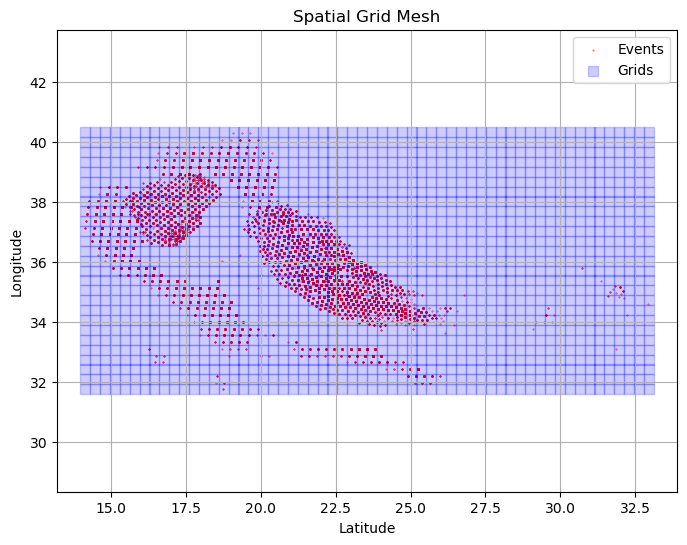

In [4]:
# Calculate the extent of latitude and longitude
min_lat = combined['lat'].min()
max_lat = combined['lat'].max()
min_lon = combined['lon'].min()
max_lon = combined['lon'].max()

# Define the size of the grid
grid_size = 0.33

# Create the latitude and longitude grids
lat_grids = np.arange(min_lat, max_lat + grid_size, grid_size)
lon_grids = np.arange(min_lon, max_lon + grid_size, grid_size)

# Create a meshgrid of latitude and longitude
mesh_lon,mesh_lat = np.meshgrid(lon_grids,lat_grids,)

# Plot the grid mesh
plt.figure(figsize=(8, 6))
plt.scatter(combined['lon'], combined['lat'], color='red', label='Events',s=0.1)
plt.scatter(mesh_lon,mesh_lat, color='blue', alpha=0.2, label='Grids', s=49, marker='s')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Spatial Grid Mesh')
plt.legend()
plt.grid(True)
plt.axis('equal')

plt.show()




In [5]:
# Calculate the number of events per grid
grid_counts = {}
for i in range(len(lat_grids) - 1):
    for j in range(len(lon_grids) - 1):
        lat_min, lat_max = lat_grids[i], lat_grids[i+1]
        lon_min, lon_max = lon_grids[j], lon_grids[j+1]
        count = combined[(combined['lat'] >= lat_min) & (combined['lat'] < lat_max) &
                         (combined['lon'] >= lon_min) & (combined['lon'] < lon_max)].shape[0]
        if count > 0:
            grid_id = f"{lat_min.round(3)},{lon_min.round(3)}"
            grid_counts[grid_id] = count

# Assign grid counts and grid ID to events
combined['gridcount'] = np.nan
combined['grid_id'] = np.nan
for index, event in combined.iterrows():
    lat, lon = event['lat'], event['lon']
    for grid_id, count in grid_counts.items():
        lat_min, lon_min = map(float, grid_id.split(","))
        lat_max, lon_max = lat_min + grid_size, lon_min + grid_size
        if lat_min <= lat < lat_max and lon_min <= lon < lon_max:
            combined.at[index, 'gridcount'] = count
            combined.at[index, 'grid_id'] = grid_id
            break

#if any entry nan for gridcount, set it to copy value of row above
combined['gridcount'] = combined['gridcount'].fillna(method='ffill')
combined['grid_id'] = combined['grid_id'].fillna(method='ffill')
         

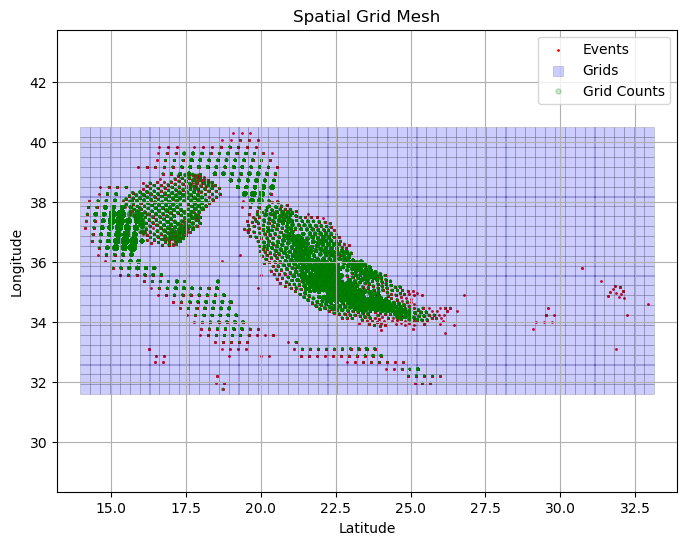

In [6]:
#plot grid counts and grid id
plt.figure(figsize=(8, 6))
plt.scatter(combined['lon'], combined['lat'], color='red', label='Events',s=1)
plt.scatter(mesh_lon,mesh_lat, color='blue', alpha=0.2, label='Grids', s=48, marker='s',linewidth =0.5, edgecolors='black')
plt.scatter(combined['lon'], combined['lat'], s=combined['gridcount']*0.015, color='green', alpha=0.2, label='Grid Counts')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Spatial Grid Mesh')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


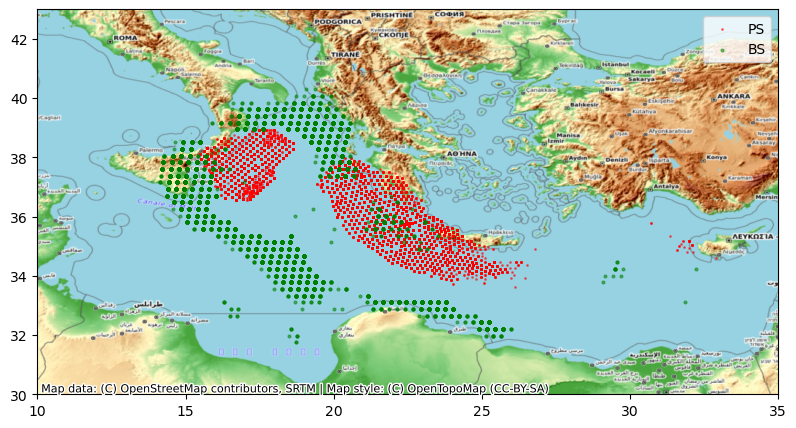

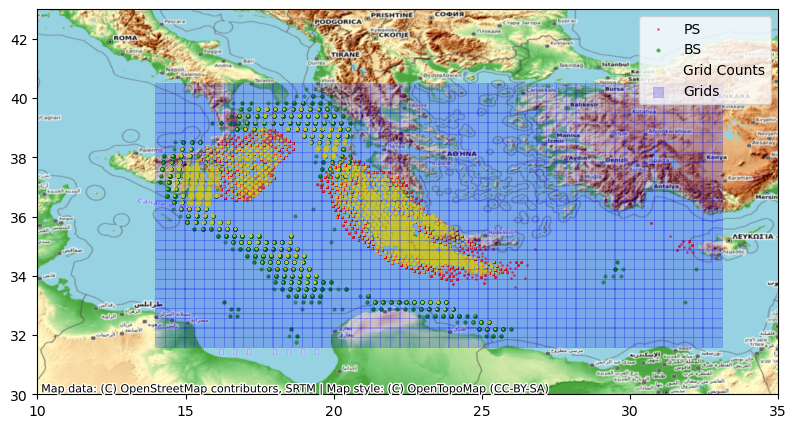

In [8]:
#plot location of events by event type
fig, ax = plt.subplots(figsize=(10,5))
#if BS or PS
ax = plt.scatter(combined[combined['id'].str[:2]=='PS']['lon'], combined[combined['id'].str[:2]=='PS']['lat'], alpha=0.5, label='PS',s=1,color='red')
ax = plt.scatter(combined[combined['id'].str[:2]=='BS']['lon'], combined[combined['id'].str[:2]=='BS']['lat'], alpha=0.5, label='BS', s=4,color='green')
# ax = plt.scatter(combined['lon'], combined['lat'], s=combined['gridcount']*0.01, color='yellow', alpha=0.1, label='Grid Counts')
# ax = plt.scatter(mesh_lon,mesh_lat, color='blue', alpha=0.2, label='Grids', s=50, marker='s',linewidth =0.5, edgecolors='blue')
plt.legend(loc='upper right')
plt.xlim(10, 35)
plt.ylim(30, 43)
ax = plt.gca()
cx.add_basemap(ax,crs='EPSG:4326', source=cx.providers.OpenTopoMap)
plt.show()
#plot location of events by event type
fig, ax = plt.subplots(figsize=(10,5))
#if BS or PS
ax = plt.scatter(combined[combined['id'].str[:2]=='PS']['lon'], combined[combined['id'].str[:2]=='PS']['lat'], alpha=0.5, label='PS',s=1,color='red')
ax = plt.scatter(combined[combined['id'].str[:2]=='BS']['lon'], combined[combined['id'].str[:2]=='BS']['lat'], alpha=0.5, label='BS', s=4,color='green')
ax = plt.scatter(combined['lon'], combined['lat'], s=combined['gridcount']*0.015, color='yellow', alpha=0.1, label='Grid Counts')
ax = plt.scatter(mesh_lon,mesh_lat, color='blue', alpha=0.2, label='Grids', s=50, marker='s',linewidth =0.5, edgecolors='blue')
plt.legend(loc='upper right')
plt.xlim(10, 35)
plt.ylim(30, 43)
ax = plt.gca()
cx.add_basemap(ax,crs='EPSG:4326', source=cx.providers.OpenTopoMap)
plt.show()

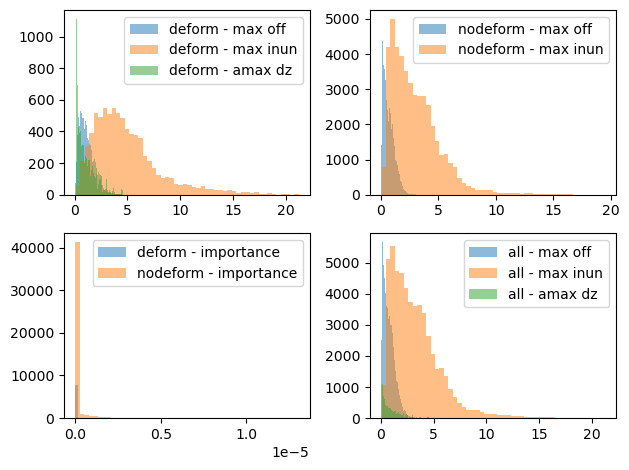

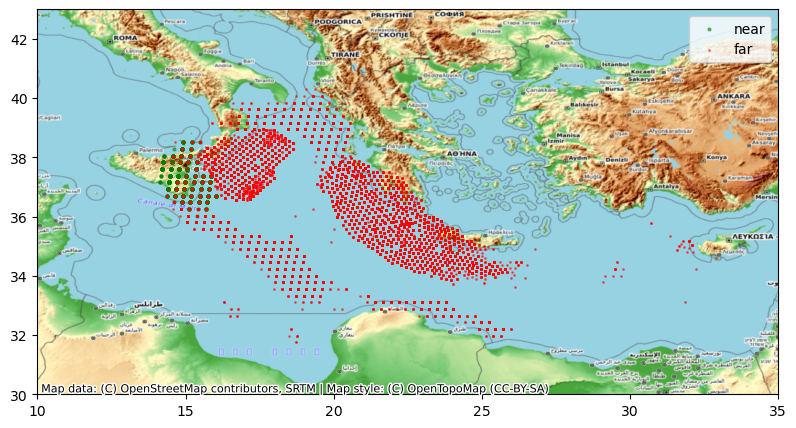

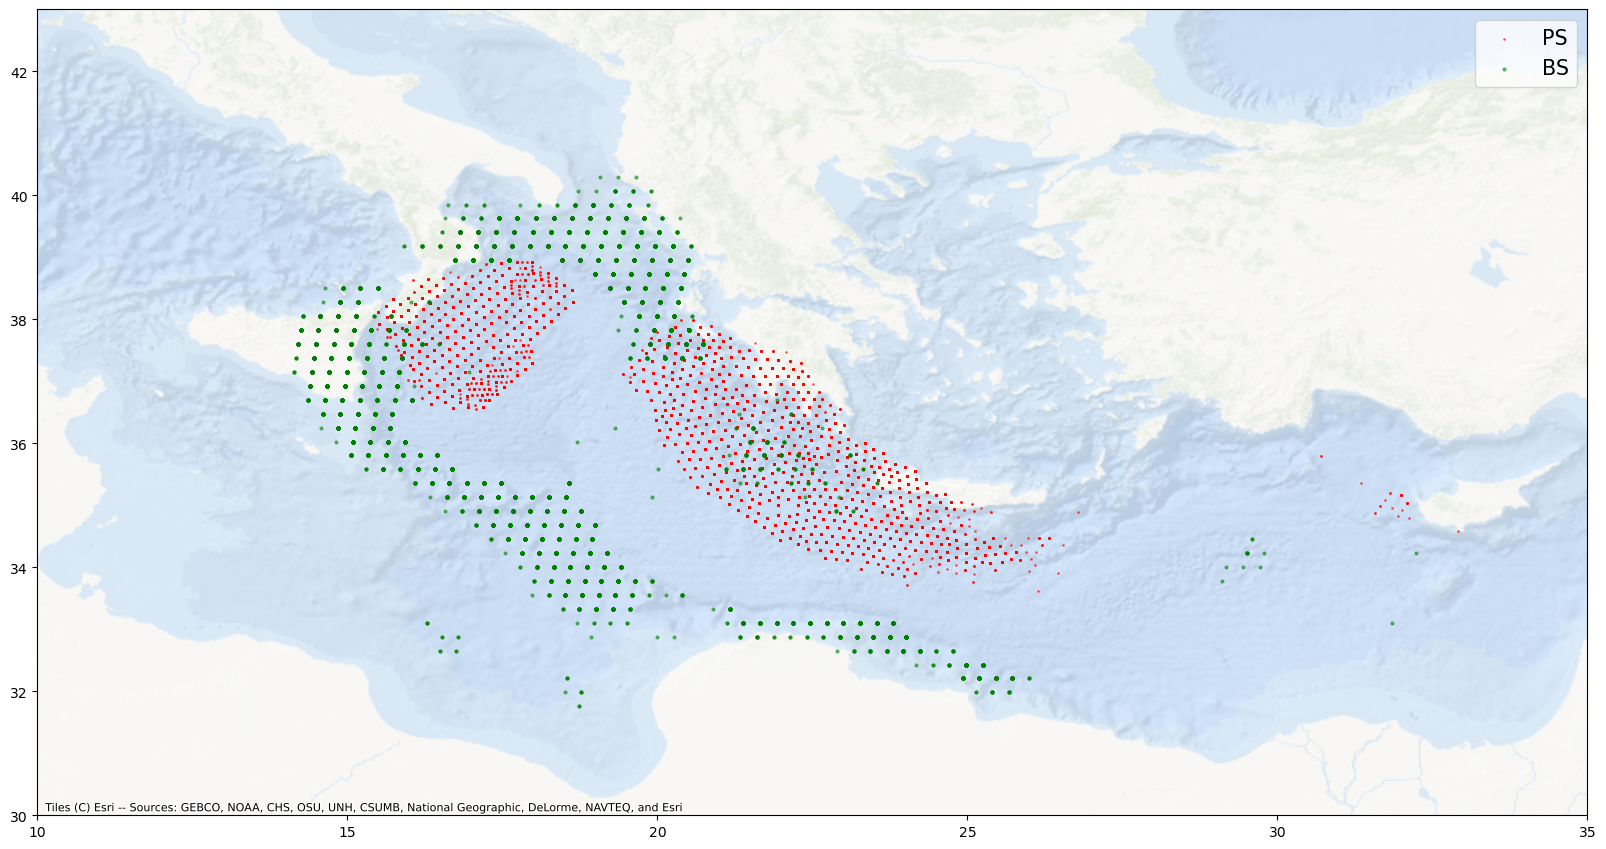

In [22]:
#distribution of events
fig, axs = plt.subplots(2, 2, tight_layout=True)
axs[0,0].hist(combined[combined['event_type']==0]['max_off'], bins=50, alpha=0.5, label='deform - max off')
axs[0,0].hist(combined[combined['event_type']==0]['max'], bins=50, alpha=0.5, label='deform - max inun')
axs[0,0].hist(combined[combined['event_type']==0]['max_absdz'], bins=50, alpha=0.5, label='deform - amax dz')
axs[0,0].legend(loc='upper right')

axs[0,1].hist(combined[combined['event_type']==1]['max_off'], bins=50, alpha=0.5, label='nodeform - max off')
axs[0,1].hist(combined[combined['event_type']==1]['max'], bins=50, alpha=0.5, label='nodeform - max inun')
# axs[0,1].hist(combined[combined['event_type']==1]['max_absdz'], bins=50, alpha=0.5, label='nodeform - amax dz')
axs[0,1].legend(loc='upper right')

axs[1,0].hist(combined[combined['event_type']==0]['importance'], bins=50, alpha=0.5, label='deform - importance')
axs[1,0].hist(combined[combined['event_type']==1]['importance'], bins=50, alpha=0.5, label='nodeform - importance')

axs[1,0].legend(loc='upper right')

axs[1,1].hist(combined['max_off'], bins=50, alpha=0.5, label='all - max off')
axs[1,1].hist(combined['max'], bins=50, alpha=0.5, label='all - max inun')
axs[1,1].hist(combined[combined['max_absdz']>0.1]['max_absdz'], bins=50, alpha=0.5, label='all - amax dz')
axs[1,1].legend(loc='upper right')

#plot location of events by event type
fig, ax = plt.subplots(figsize=(10,5))
ax = plt.scatter(combined[combined['event_type']==0]['lon'], combined[combined['event_type']==0]['lat'], alpha=0.5, label='near', s=4,color='green')
ax = plt.scatter(combined[combined['event_type']==1]['lon'], combined[combined['event_type']==1]['lat'], alpha=0.5, label='far',s=1,color='red')
plt.legend(loc='upper right')
plt.xlim(10, 35)
plt.ylim(30, 43)
ax = plt.gca()
cx.add_basemap(ax,crs='EPSG:4326', source=cx.providers.OpenTopoMap)

#plot location of events by event type
fig, ax = plt.subplots(figsize=(20,15))
#if BS or PS
ax = plt.scatter(combined[combined['id'].str[:2]=='PS']['lon'], combined[combined['id'].str[:2]=='PS']['lat'], alpha=0.5, label='PS',s=1,color='red')
ax = plt.scatter(combined[combined['id'].str[:2]=='BS']['lon'], combined[combined['id'].str[:2]=='BS']['lat'], alpha=0.5, label='BS', s=4,color='green')
plt.legend(loc='upper right',fontsize=15)
plt.xlim(10, 35)
plt.ylim(30, 43)
ax = plt.gca()
cx.add_basemap(ax,crs='EPSG:4326', source=cx.providers.Esri.OceanBasemap, alpha=0.5)
plt.show()



In [ ]:
cx.providers

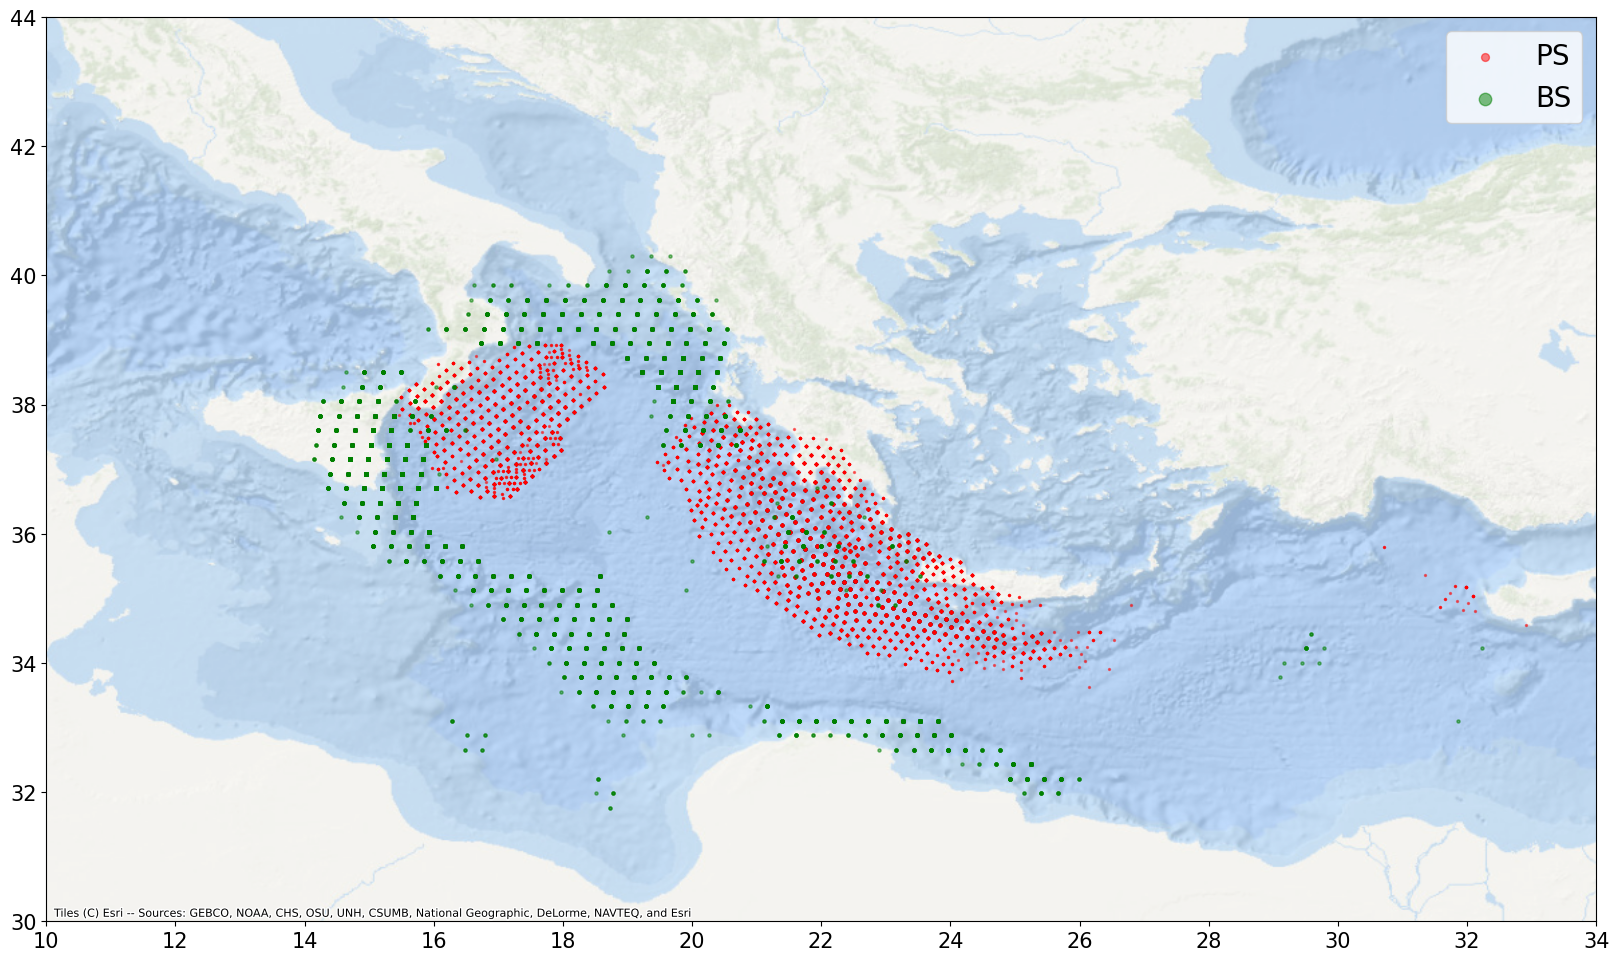

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx  # Import contextily for basemap

fig, ax = plt.subplots(figsize=(20, 15))

# Filter data by event type and create scatter plots
ps_data = combined[combined['id'].str[:2] == 'PS']
bs_data = combined[combined['id'].str[:2] == 'BS']

ax.scatter(ps_data['lon'], ps_data['lat'], alpha=0.5, label='PS', s=2, color='red')
ax.scatter(bs_data['lon'], bs_data['lat'], alpha=0.5, label='BS', s=5, color='green')

plt.legend(loc='upper right', fontsize=20, markerscale=4)
plt.xlim(12, 34)
plt.ylim(31, 41)
plt.xticks(np.arange(10, 35, 2), fontsize=15)
plt.yticks(np.arange(30, 45, 2), fontsize=15)

# Add a basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Esri.OceanBasemap, alpha=0.75)

plt.savefig(MLDir + f'/resources/plots/map_events{str(len(combined))}_{reg}_{columnname}.png', bbox_inches='tight')


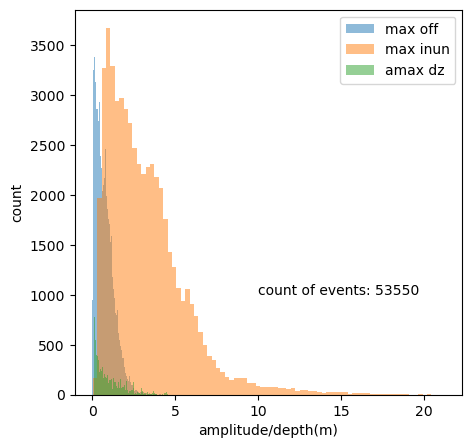

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.hist(combined['max_off'], bins=80, alpha=0.5, label='max off')
axs.hist(combined['max'], bins=80, alpha=0.5, label='max inun')
axs.hist(combined[combined['max_absdz']>0.1]['max_absdz'], bins=80, alpha=0.5, label='amax dz')
axs.text(10, 1000, 'count of events: '+str(len(combined)))
axs.legend(loc='upper right')
#label axes
axs.set(xlabel='amplitude/depth(m)', ylabel='count')
plt.savefig(MLDir + f'/resources/plots/dist_events{str(len(combined))}_{reg}_{columnname}.png', bbox_inches='tight')


In [62]:
# #filter events by PS for train and test for a given region of lat and long
# reg_lim = [33,38,19,27] #ymin,ymax,xmin,xmax #Helenic
# # reg_lim = [33,39,15,20] #ymin,ymax,xmin,xmax #Calabria
# reg_lim = [34,38,20,24] #ymin,ymax,xmin,xmax #4test
# filter_eve = combined[ (combined['lat']>=reg_lim[0]) & (combined['lat']<=reg_lim[1]) & (combined['lon']>=reg_lim[2]) & (combined['lon']<=reg_lim[3])]

# PS_eve = filter_eve[filter_eve['id'].str[:2]=='PS']
# BS_eve = filter_eve[filter_eve['id'].str[:2]=='BS']

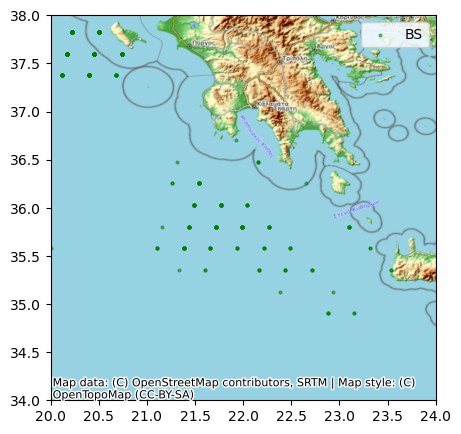

In [63]:
# #plot location of events by event type
# fig, ax = plt.subplots(figsize=(10,5))
# #if BS or PS
# # ax = plt.scatter(PS_eve['lon'], PS_eve['lat'], alpha=0.25, label='PS',s=3,color='red')
# ax = plt.scatter(BS_eve['lon'], BS_eve['lat'], alpha=0.5, label='BS', s=4,color='green')
# plt.legend(loc='upper right')
# plt.xlim(reg_lim[2], reg_lim[3])
# plt.ylim(reg_lim[0], reg_lim[1])
# ax = plt.gca()
# cx.add_basemap(ax,crs='EPSG:4326', source=cx.providers.OpenTopoMap)
# plt.show()

In [64]:
# #save sampling input to info folder
# # PS_eve.to_csv(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/info/PS_Helenic_sampling_input_{reg}_{columnname}.csv', index=False)
# BS_eve.id.to_csv(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/info/BS_Helenic_sampling_input_{reg}_{columnname}_test.csv', index=False)
# BS_eve.to_csv(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/info/BS_Helenic_sampling_input_{reg}_{columnname}_testinfo.csv', index=False)

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx

np.random.seed(0)

def sample_train_events(data, #input dataframe with event info 
                        importance_column='mean_prob', #column name for importance weighted sampling
                        samples_per_bin=10, #no of events to sample per bin
                        bin_def = [0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,5.0], #bin width for wave height,
                        basis_var='max_off' #variable to bin 
                        ): 

    #define bin edges
    bin_start = bin_def[:-1]
    bin_end = bin_def[1:]

    if np.any((data['mean_prob'] < 0) | (data[importance_column] < 0)):
        raise ValueError('event_rates and importance parameter must be nonnegative')
    
    sample = []
    for bin in list(zip(bin_start, bin_end)):
       
        #get events in this bin
        events_in_bin = data[(data[basis_var] >= bin[0]) & (data[basis_var] < bin[1])]
        print('Sampling',samples_per_bin, 'events in bin',bin,'from',len(events_in_bin),'events')
        
        rate_with_this_bin = np.sum(events_in_bin['mean_prob'] )    
        events_in_bin_copy = events_in_bin.copy()

        #sort by lat and lon
        events_in_bin_copy.sort_values(by=['lat', 'lon'], inplace=True)

        if importance_column == 'gridcount' or importance_column == 'LocationCount':
            # Print count of events per grid and print grid ID with the minimum count
            grid_counts = events_in_bin_copy.groupby('grid_id').count()['id']
            # Add the weights column
            events_in_bin_copy['norm_wt'] = events_in_bin_copy['grid_id'].map(lambda x: 1 / grid_counts[x])
            events_in_bin_copy['norm_wt'] /= np.sum(events_in_bin_copy['norm_wt'])      
        else:
            events_in_bin_copy.loc[:, 'norm_wt'] = events_in_bin[importance_column] / np.sum(events_in_bin[importance_column])  

        if samples_per_bin > 0 and np.sum(events_in_bin_copy['norm_wt']) > 0:
            #sample events from this bin weighted by norm_wt
            if len(events_in_bin) <= samples_per_bin:
                print('Less scenario to sample in this bin',bin,' -- need to be careful using samples will use sample with replacement')
                sampled_ids = np.random.choice(events_in_bin['id'],
                                                size=samples_per_bin,
                                                p=events_in_bin_copy['norm_wt'],
                                                replace=True,
                                                )
            else:
                sampled_ids = np.random.choice(events_in_bin['id'],
                                                size=samples_per_bin,
                                                p=events_in_bin_copy['norm_wt'],
                                                replace=False,
                                                )            
        #get the sampled events
        sample.append(pd.DataFrame({
            'id': sampled_ids,
            'bin_start': np.repeat(bin[0], samples_per_bin),
            'bin_end': np.repeat(bin[1], samples_per_bin),
            'rate_with_this_bin': np.repeat(rate_with_this_bin, samples_per_bin)
        }))
    
    return sample


In [26]:
#select particular representative gauge
reg = 'CT'

if reg == 'SR':
    columnname = str(54)
elif reg == 'CT':
    columnname = str(41)

#read combined dataframe
combined = pd.read_csv(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/info/sampling_input_{reg}_{columnname}.csv')
# far = combined.groupby('event_type').get_group(1)
# near = combined.groupby('event_type').get_group(0)
MLDir = '/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami' 

Sampling 50 events in bin (0.1, 0.18979591836734694) from 1113 events
Sampling 50 events in bin (0.18979591836734694, 0.2795918367346939) from 712 events
Sampling 50 events in bin (0.2795918367346939, 0.3693877551020408) from 610 events
Sampling 50 events in bin (0.3693877551020408, 0.4591836734693878) from 422 events
Sampling 50 events in bin (0.4591836734693878, 0.5489795918367347) from 403 events
Sampling 50 events in bin (0.5489795918367347, 0.6387755102040816) from 412 events
Sampling 50 events in bin (0.6387755102040816, 0.7285714285714286) from 294 events
Sampling 50 events in bin (0.7285714285714286, 0.8183673469387756) from 317 events
Sampling 50 events in bin (0.8183673469387756, 0.9081632653061225) from 310 events
Sampling 50 events in bin (0.9081632653061225, 0.9979591836734695) from 205 events
Sampling 50 events in bin (0.9979591836734695, 1.0877551020408165) from 254 events
Sampling 50 events in bin (1.0877551020408165, 1.1775510204081634) from 247 events
Sampling 50 even

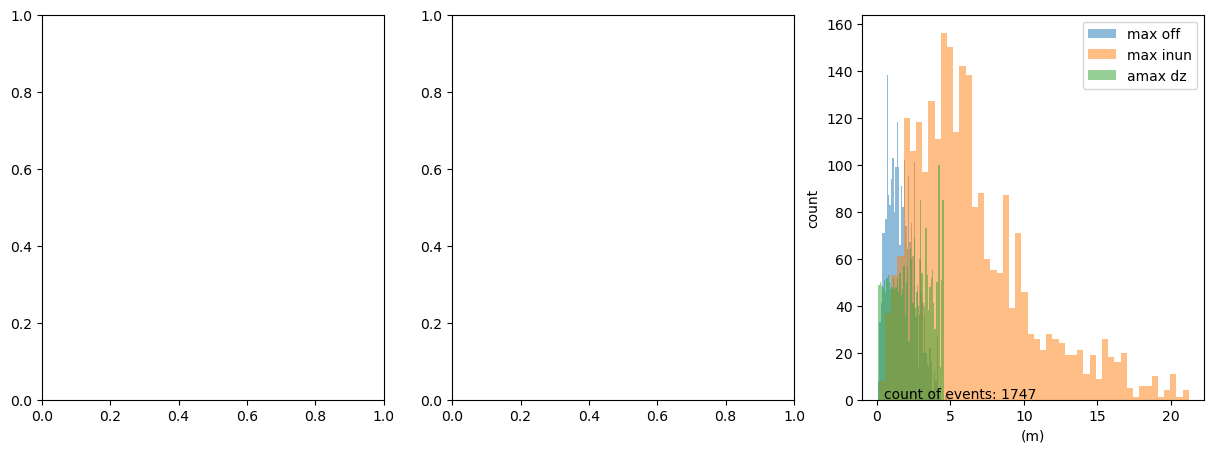

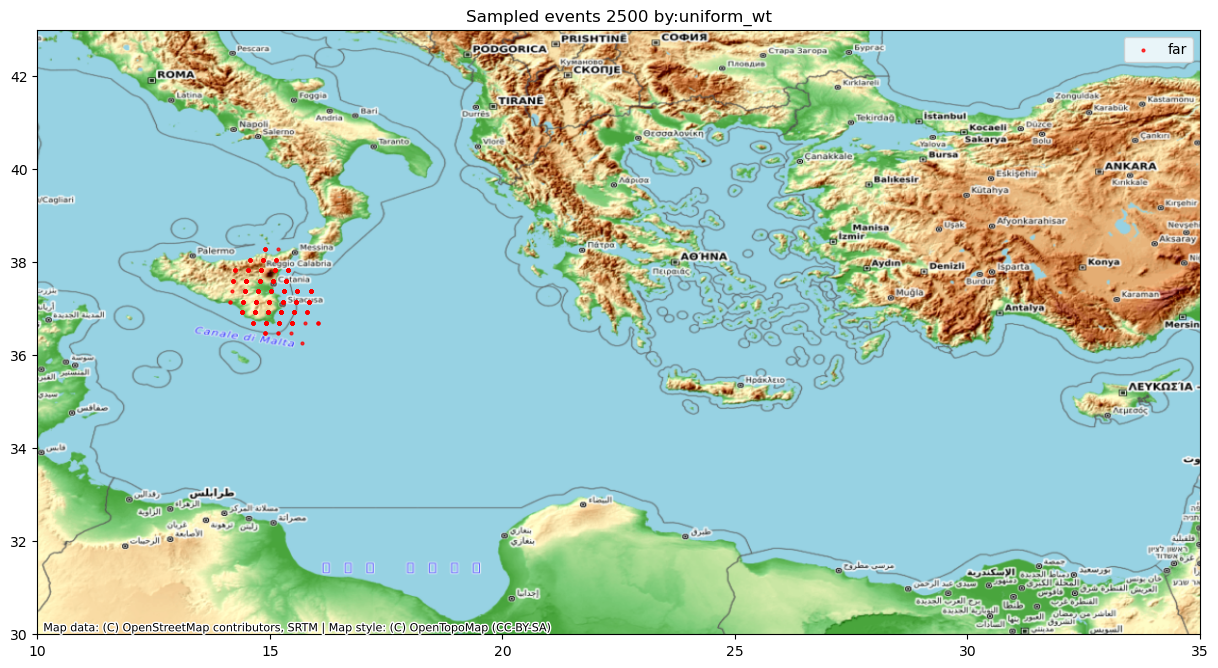

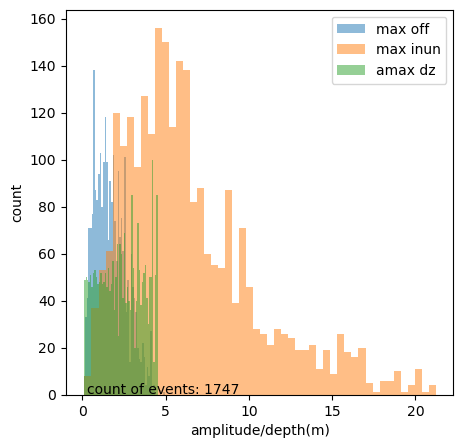

In [38]:
#'split sampling in two steps for event type 0 and 1 then merge'
wt_para = 'uniform_wt' #'LocationCount', 'mean_prob', 'importance', 'uniform',gridcount

if reg == 'SR':
    samples_per_bin = 25
    bin_splits = 20
    max_off = 7
elif reg == 'CT':
    samples_per_bin = 50
    bin_splits = 50
    max_off = 4.5


sample_step0 = sample_train_events(combined.groupby('event_type').get_group(0),
                                importance_column=wt_para,
                                samples_per_bin=samples_per_bin,
                                bin_def = np.append(np.linspace(0.1,max_off,bin_splits), 99),
                                basis_var='max_absdz')

#use random half of the events for training sample
# combined_new = combined.sample(frac=1, random_state=0).reset_index(drop=True)

# sample_step1 = sample_train_events(combined_new.groupby('event_type').get_group(1),
#                                 importance_column=wt_para, 
#                                 samples_per_bin=samples_per_bin,
#                                 bin_def = np.append(np.linspace(0,max_off,bin_splits), 99))

# sample_test = pd.concat([pd.concat(sample_step0, axis=0), pd.concat(sample_step1, axis=0)], axis=0)
sample_test = pd.concat(sample_step0, axis=0)

#check unique events in sample
print(len(sample_test['id'].unique()),'out of ',len(sample_test))

#merge columns from combined to sample_test based on id
sample_test = pd.merge(sample_test, combined, on='id', how='left')

#plot 
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# axs[0].hist(sample_test[sample_test['event_type']==0]['max_off'], bins=bin_splits, alpha=0.5, label='near - max off')
# axs[0].hist(sample_test[sample_test['event_type']==0]['max'], bins=bin_splits, alpha=0.5, label='near - max inun')
# axs[0].text(0.5, 0.5, 'count of type 0 events: '+str(len(sample_test[sample_test['event_type']==0])))
# axs[0].legend(loc='upper right')

# axs[1].hist(sample_test[sample_test['event_type']==1]['max_off'], bins=bin_splits, alpha=0.5, label='far - max off')
# axs[1].hist(sample_test[sample_test['event_type']==1]['max'], bins=bin_splits, alpha=0.5, label='far - max inun')
# axs[1].text(0.5, 0.5,'count of type 0 events: '+str(len(sample_test[sample_test['event_type']==1])))
# axs[1].legend(loc='upper right')

axs[2].hist(sample_test['max_off'], bins=bin_splits, alpha=0.5, label='max off')
axs[2].hist(sample_test['max'], bins=bin_splits, alpha=0.5, label='max inun')
axs[2].hist(sample_test[sample_test['max_absdz']>0.1]['max_absdz'], bins=bin_splits, alpha=0.5, label='amax dz')
axs[2].text(0.5, 0.5, 'count of events: '+str(len(sample_test['id'].unique())))
axs[2].legend(loc='upper right')
#label axes
axs[2].set(xlabel='(m)', ylabel='count')
# plt.savefig(MLDir + f'/model/{reg}/plot/sampledist_events{str(len(sample_test))}_{reg}_{columnname}.png', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(15,10))
ax.title.set_text('Sampled events ' + str(len(sample_test)) + ' by:' + wt_para)
ax = plt.scatter(sample_test[sample_test['event_type']==0]['lon'], sample_test[sample_test['event_type']==0]['lat'], alpha=0.75, label='far',s=4, color='red')
# ax = plt.scatter(sample_test[sample_test['event_type']==0]['lon'], sample_test[sample_test['event_type']==0]['lat'], alpha=0.75, label='near', s=5, color='green')
plt.legend(loc='upper right')
plt.xlim(10, 35)
plt.ylim(30, 43)
ax = plt.gca()
cx.add_basemap(ax,crs='EPSG:4326', source=cx.providers.OpenTopoMap)
plt.savefig(MLDir + f'/model/{reg}/plot/samplemap_events{str(len(sample_test))}_{reg}_{columnname}.png', bbox_inches='tight')

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.hist(sample_test['max_off'], bins=bin_splits, alpha=0.5, label='max off')
axs.hist(sample_test['max'], bins=bin_splits, alpha=0.5, label='max inun')
axs.hist(sample_test[sample_test['max_absdz']>0.1]['max_absdz'], bins=bin_splits, alpha=0.5, label='amax dz')
axs.text(0.25, 0.5, 'count of events: '+str(len(sample_test['id'].unique())))
axs.legend(loc='upper right')
#label axes
axs.set(xlabel='amplitude/depth(m)', ylabel='count')
plt.savefig(MLDir + f'/model/{reg}/plot/sampledist_events{str(len(sample_test))}_{reg}_{columnname}.png', bbox_inches='tight')



In [50]:
#save list of ids to txt file for training
#for building model
sample_test['id'].to_csv(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/events/sample_events{str(len(sample_test))}_{reg}_{columnname}.txt', header=False, index=None)

#evaluation of model by removing sample from combined ie the test set
deform_combine = combined.groupby('event_type').get_group(0)
deform_combine.to_csv(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/info/deform_eve_{str(len(deform_combine))}.csv', index=False)
deform_test = deform_combine[~deform_combine['id'].isin(sample_test['id'])]
len_test = len(deform_test['id'].unique())
pd.DataFrame(deform_test['id'].unique()).to_csv(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/events/shuffled_events_test_{reg}_{str(len_test)}.txt', header=False, index=None)


In [21]:
# pd.DataFrame(BS_eve['id'].unique()).to_csv(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/events/sample_events{str(len(BS_eve))}_{reg}_{columnname}.txt', header=False, index=None)

In [43]:
size_list = ['2500']#'300','600','1200','2400']
reg_list = ['CT']

for reg in reg_list:
    for size in size_list:
        #select particular representative gauge    
        if reg == 'SR':
            columnname = str(54)
        elif reg == 'CT':
            columnname = str(41)

        #filter events with lower than threshold of 0.1 at atleast one station
        offshore_threshold = 0.1
        onshore_threshold = 0.20
        split = 0.75

        #offshore
        allpts_max = np.loadtxt(f'{MLDir}/data/info/grid0_allpts87_alleve53550.offshore.txt', dtype='str',skiprows=1)

        if reg == 'CT':
            GaugeNo = list(range(35,44)) #for Catania
            MainGauge = str(41) #for Catania
        elif reg == 'SR':
            GaugeNo = list(range(53,58)) #for Siracusa
            MainGauge = str(54) #for Siracusa

        event_list = np.loadtxt(f'{MLDir}/data/events/sample_events{size}_{reg}_{columnname}.txt', dtype='str') #for harcode

        #find index of event list in allpts_max wiht duplicate events
        event_list_index = np.array([np.where(allpts_max[:,0]==event)[0] for event in event_list]).flatten()
        allpts_max = allpts_max[event_list_index]
        Gauge_Max = allpts_max[:,GaugeNo]
        maxPerEve = Gauge_Max.astype(float).max(axis=1)

        #onshore
        inun_info = np.loadtxt(f'{MLDir}/data/info/CDepth_{reg}_alleve53550.onshore.txt', dtype='str',skiprows=1)
        inun_info = inun_info[event_list_index]
        Inun_Max = inun_info[:,2] #max inundation depth is the 3rd column

        #filter events greater than thresholds for gauge and min inundation depth
        offshore_check = maxPerEve>offshore_threshold
        onshore_check = Inun_Max.astype(float)>onshore_threshold
        print(len(event_list), len(offshore_check), len(onshore_check))

        overall_check = offshore_check & onshore_check
        event_list = event_list[overall_check]

        #pick unique events only
        event_list = np.unique(event_list)

        #shuffle events
        np.random.shuffle(event_list)

        #split events in train and test and validation as 60:20:20
        train_events = event_list[:int(len(event_list)*split)] 
        test_events = event_list[int(len(event_list)*split):]

        print(len(train_events), len(test_events))

        #save events in file
        np.savetxt(f'{MLDir}/data/events/shuffled_events_{reg}_{size}.txt', event_list, fmt='%s')
        np.savetxt(f'{MLDir}/data/events/train_events_{reg}_{size}.txt', train_events, fmt='%s')
        np.savetxt(f'{MLDir}/data/events/test_events_{reg}_{size}.txt', test_events, fmt='%s')

2500 2500 2500
1309 437


In [51]:
import folium
import pandas as pd

#Create location keyword
DF_eve = pd.read_csv('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/info/deform_eve_7929.csv')

#event_list train events, pick form DF_eve
Train_eve = DF_eve[DF_eve['id'].isin(train_events)]

#Unique EQ locations overall
unique_locations = len(DF_eve['Location'].unique())
print('uniques EQ locations in the dataset:',unique_locations)

#filter 1 row per unique location from list of DF_eve
DF_eve_unique = DF_eve.drop_duplicates(subset=['Location'], keep='first')
#reset index
DF_eve_unique.reset_index(drop=True, inplace=True)

#unique locations for training events
unique_locations_train = len(Train_eve['Location'].unique())
print('uniques EQ locations in the training dataset:',unique_locations_train)

#filter 1 row per unique location from list of train list
Train_eve_unique = Train_eve.drop_duplicates(subset=['Location'], keep='first')
#reset index
Train_eve_unique.reset_index(drop=True, inplace=True)

data_pts = np.loadtxt('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/resources/raw/pois_eastern_sicily_2km.txt', dtype=str)
id_pts = data_pts[:, 0]
lon_pts = data_pts[:, 1].astype(float)
lat_pts = data_pts[:, 2].astype(float)
z_pts = data_pts[:, 3].astype(float)

#Create a map with the unique locations
eve_map = folium.Map(location=[np.mean(DF_eve_unique['lat']),
                               np.mean(DF_eve_unique['lon'])],
                               zoom_start=7, tiles='OpenStreetMap')

# Basemaps
folium.TileLayer(tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True,
        show = False).add_to(eve_map)

# Create a feature group for the offshore points and eq loc 
fg_pts = folium.FeatureGroup(name='Offshore Points Txt').add_to(eve_map)
fg_Unq_EQ = folium.FeatureGroup(name='Unique EQ Location').add_to(eve_map)
fg_Train_EQ = folium.FeatureGroup(name='Train EQ Location').add_to(eve_map)

for i in range(len(DF_eve_unique)-1):
    folium.CircleMarker([DF_eve_unique.loc[i+1,'lat'], DF_eve_unique.loc[i+1,'lon']],radius= 3,color = 'green',opacity=0.95 ).add_to(fg_Unq_EQ)
folium.LayerControl().add_to(eve_map)

for i in range(len(Train_eve_unique)-1):
    folium.CircleMarker([Train_eve_unique.loc[i+1,'lat'], Train_eve_unique.loc[i+1,'lon']],radius= 1,color = 'red',opacity=0.95 ).add_to(fg_Train_EQ)
folium.LayerControl().add_to(eve_map)

for id, lat, lon,z in zip(id_pts, lat_pts, lon_pts, z_pts):
    info = f"ID:{id}, Depth: {z} "  # Create tooltip string
    folium.CircleMarker(location=[lat, lon],
                  tooltip=info,radius=0.5,
                  icon=folium.Icon(color='blue', icon='')).add_to(fg_pts)
    


# # Save the map as an HTML file or plot here
# # eve_map.save('tsu_PS_eve_map.html')

eve_map


uniques EQ locations in the dataset: 57
uniques EQ locations in the training dataset: 42


In [27]:
# #read events from file for region
# import glob
# #find files with *CT_41.txt

# #read test sample events
# test_list_PS = pd.DataFrame(PS_test['id'].unique())

# np.random.shuffle(test_list_PS[0].values)
# test_list_PS = test_list_PS.drop_duplicates()

# #save test list
# np.savetxt(f'{MLDir}/data/events/shuffled_events_test_CT_{str(len(test_list_PS))}.txt', test_list_PS, fmt='%s')


In [23]:
# #read events from file for region
# import glob
# #find files with *CT_41.txt

# BS_test = BS_eve

# #read test sample events
# test_list_BS = pd.DataFrame(BS_test['id'].unique())

# np.random.shuffle(test_list_BS[0].values)
# test_list_BS = test_list_BS.drop_duplicates()

# #save test list
# np.savetxt(f'{MLDir}/data/events/shuffled_events_test_CT_{str(len(test_list_BS))}.txt', test_list_BS, fmt='%s')


In [28]:
# #save
# regions = ['SR','CT']

# for region in regions:
#         # shuffling test list
#         if region == 'SR':
#                 test_list = test_list_SR
#         elif region == 'CT':
#                 test_list = test_list_CT

#         test_list = np.random.permutation(test_list)

#         #split and save as 4 different files
#         test_list_1 = test_list[:int(len(test_list)/4)]
#         test_list_2 = test_list[int(len(test_list)/4):int(len(test_list)/2)]
#         test_list_3 = test_list[int(len(test_list)/2):int(len(test_list)*3/4)]
#         test_list_4 = test_list[int(len(test_list)*3/4):]

#         list_files = [test_list_1,test_list_2,test_list_3,test_list_4]

#         for i in range(4):
#                 test_list = list_files[i]
#                 np.savetxt(f'{MLDir}/data/events/shuffled_events_test_{region}_{i}.txt', test_list, fmt='%s')



In [ ]:
# import subprocess
# from concurrent.futures import ThreadPoolExecutor
# import time

# def run_slurm_job(reg,train_size):
#     sbatch_script = f"""#!/bin/bash
# #SBATCH --job-name={reg}-{train_size} # Job name
# #SBATCH --nodes=1 # number of nodes
# #SBATCH --ntasks-per-node=1 # number of tasks
# #SBATCH --time=0-09:00 # time limit (D-HH:MM)
# #SBATCH -p gpuq # partition
# ##SBATCH --gres=gpu:1 # number of GPUs
# #SBATCH --mem=64G # memory pool for all cores
# #SBATCH --output ./sbatch/run-%j-{reg}-{train_size}.txt       # Standard out goes to this file
# #SBATCH --error ./sbatch/error-%j-{reg}-{train_size}.txt      # Standard err goes to this file

# begin=`date +%s`
# echo node: $HOSTNAME
# echo start time: `date`
# echo ...........

# source /home/${{USER}}/.bash_profile
# conda activate /mnt/beegfs/nragu/tsunami/env
# python main.py with 'reg={reg}' 'train_size={train_size}' 

# echo ...........
# end=`date +%s`
# elapsed=`expr $end - $begin`
# echo Time taken: $elapsed seconds
# """

#     sbatch_file = f"sbatch_{reg}_{train_size}.sh"
#     with open(sbatch_file, "w") as f:
#         f.write(sbatch_script)

#     command = f"sbatch {sbatch_file}"
#     subprocess.run(command, shell=True)

# train_sizes = ['300','500','600','1200','2400'] 
# regions = ['CT']

# #launch as job queue, 4 jobs at a time
# max_concurrent_jobs = 1

# def run_jobs():
#     with ThreadPoolExecutor(max_workers=max_concurrent_jobs) as executor:
#         futures = [executor.submit(run_slurm_job, reg, size) for reg in regions for size in train_sizes]
#         # Wait for all jobs to complete
#         for future in futures:
#             future.result()
# run_jobs()

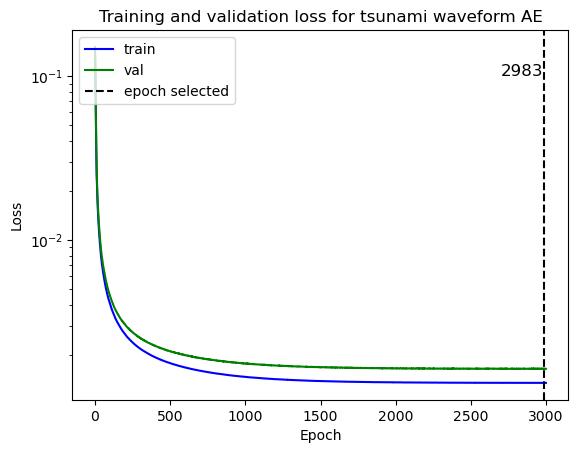

In [46]:
# #plot train and test loss for pretraining and fine tuning

# train_epoch_losses = np.load('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/CT/out/train_loss_offshore_ch_[64, 128, 256]_3200.npy')
# test_epoch_losses = np.load('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/CT/out/test_loss_offshore_ch_[64, 128, 256]_3200.npy')

# plt.plot(train_epoch_losses, color='blue')
# plt.plot(test_epoch_losses, color='green')
# plt.axvline(x=2983, color='black', linestyle='--')
# plt.text(2700, 0.1, 2983, fontsize=12)
# plt.legend(['train', 'val', 'epoch selected'], loc='upper left')
# plt.title(f"Training and validation loss for offshore AE")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.yscale('log')

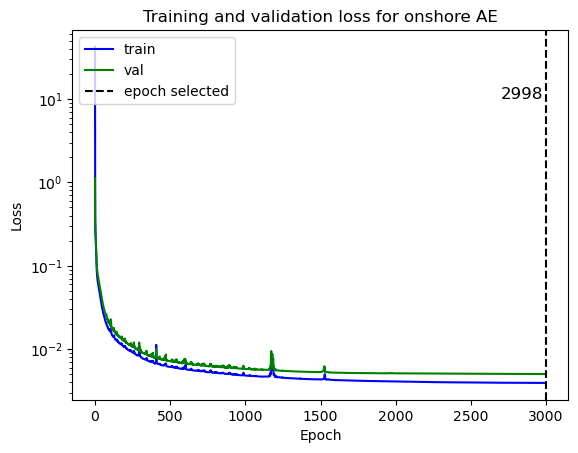

In [58]:
# #plot train and test loss for pretraining and fine tuning

# train_epoch_losses = np.load('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/CT/out/train_loss_onshore_ch_[64, 64]_3200.npy')
# test_epoch_losses = np.load('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/CT/out/test_loss_onshore_ch_[64, 64]_3200.npy')

# plt.plot(train_epoch_losses, color='blue')
# plt.plot(test_epoch_losses, color='green')
# plt.axvline(x=2998, color='black', linestyle='--')
# plt.text(2700, 10, 2998, fontsize=12)
# plt.legend(['train', 'val', 'epoch selected'], loc='upper left')
# plt.title(f"Training and validation loss for onshore AE")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.yscale('log')

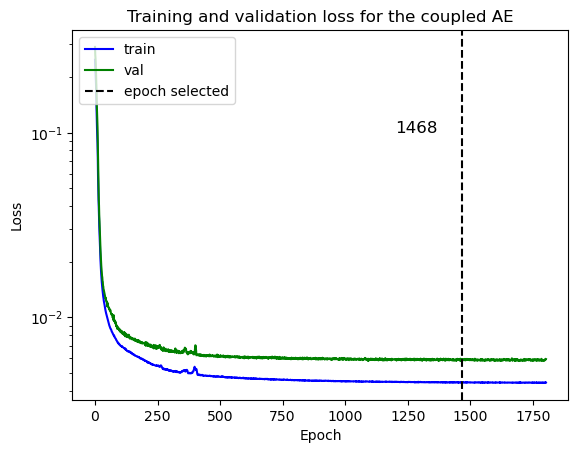

In [59]:
# #plot train and test loss for pretraining and fine tuning

# train_epoch_losses = np.load('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/CT/out/train_loss_couple_ch_[64, 64]_3200.npy')
# test_epoch_losses = np.load('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/CT/out/test_loss_couple_ch_[64, 64]_3200.npy')

# plt.plot(train_epoch_losses, color='blue')
# plt.plot(test_epoch_losses, color='green')
# plt.axvline(x=1468, color='black', linestyle='--')
# plt.text(1200, 0.1, 1468, fontsize=12)
# plt.legend(['train', 'val', 'epoch selected'], loc='upper left')
# plt.title(f"Training and validation loss for the coupled AE")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.yscale('log')